In [2]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *

In [3]:
tic = 29984014

In [4]:
# we need to normalize the light curve here.
fig, ax = plt.subplots(3, figsize=(15,15))
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
ax[0].scatter(lc['Time'],lc['Flux'],s=1,label='Data')
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux'],c='C3',label='Rolling Median')
ax[0].set(ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

lc, p = polynorm(lc, deg=7)

vals = np.polyval(p, lc['Time'])
ax[1].scatter(lc['Time'],lc['Flux'],s=1,label='Data')
ax[1].plot(lc['Time'],vals,c='C3',label='Fit')
ax[1].set(ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
ax[1].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})


ax[2].scatter(lc['Time'],lc['NormFlux'])
ax[2].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')


TypeError: 'Figure' object is not iterable

<Figure size 1080x1080 with 0 Axes>

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


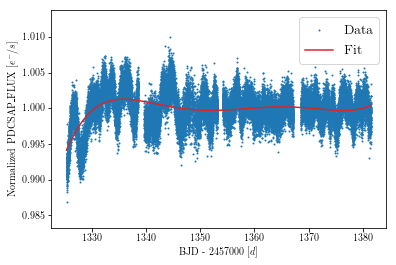

In [8]:
lc, p = polynorm(lc, deg=7)
vals = np.polyval(p, lc['Time'])
plt.scatter(lc['Time'],lc['Flux'],s=1,label='Data')
plt.plot(lc['Time'],vals,c='C3',label='Fit')
plt.gca().set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


f_Ny = 323.83746567083887, f_R = 0.017787891882718898
10
20
30
40
50
60
Found 64 frequencies
33 unique frequencies
0.6796311837715954
1.019446775657393
1.3592623675431907
1.6990779594289884


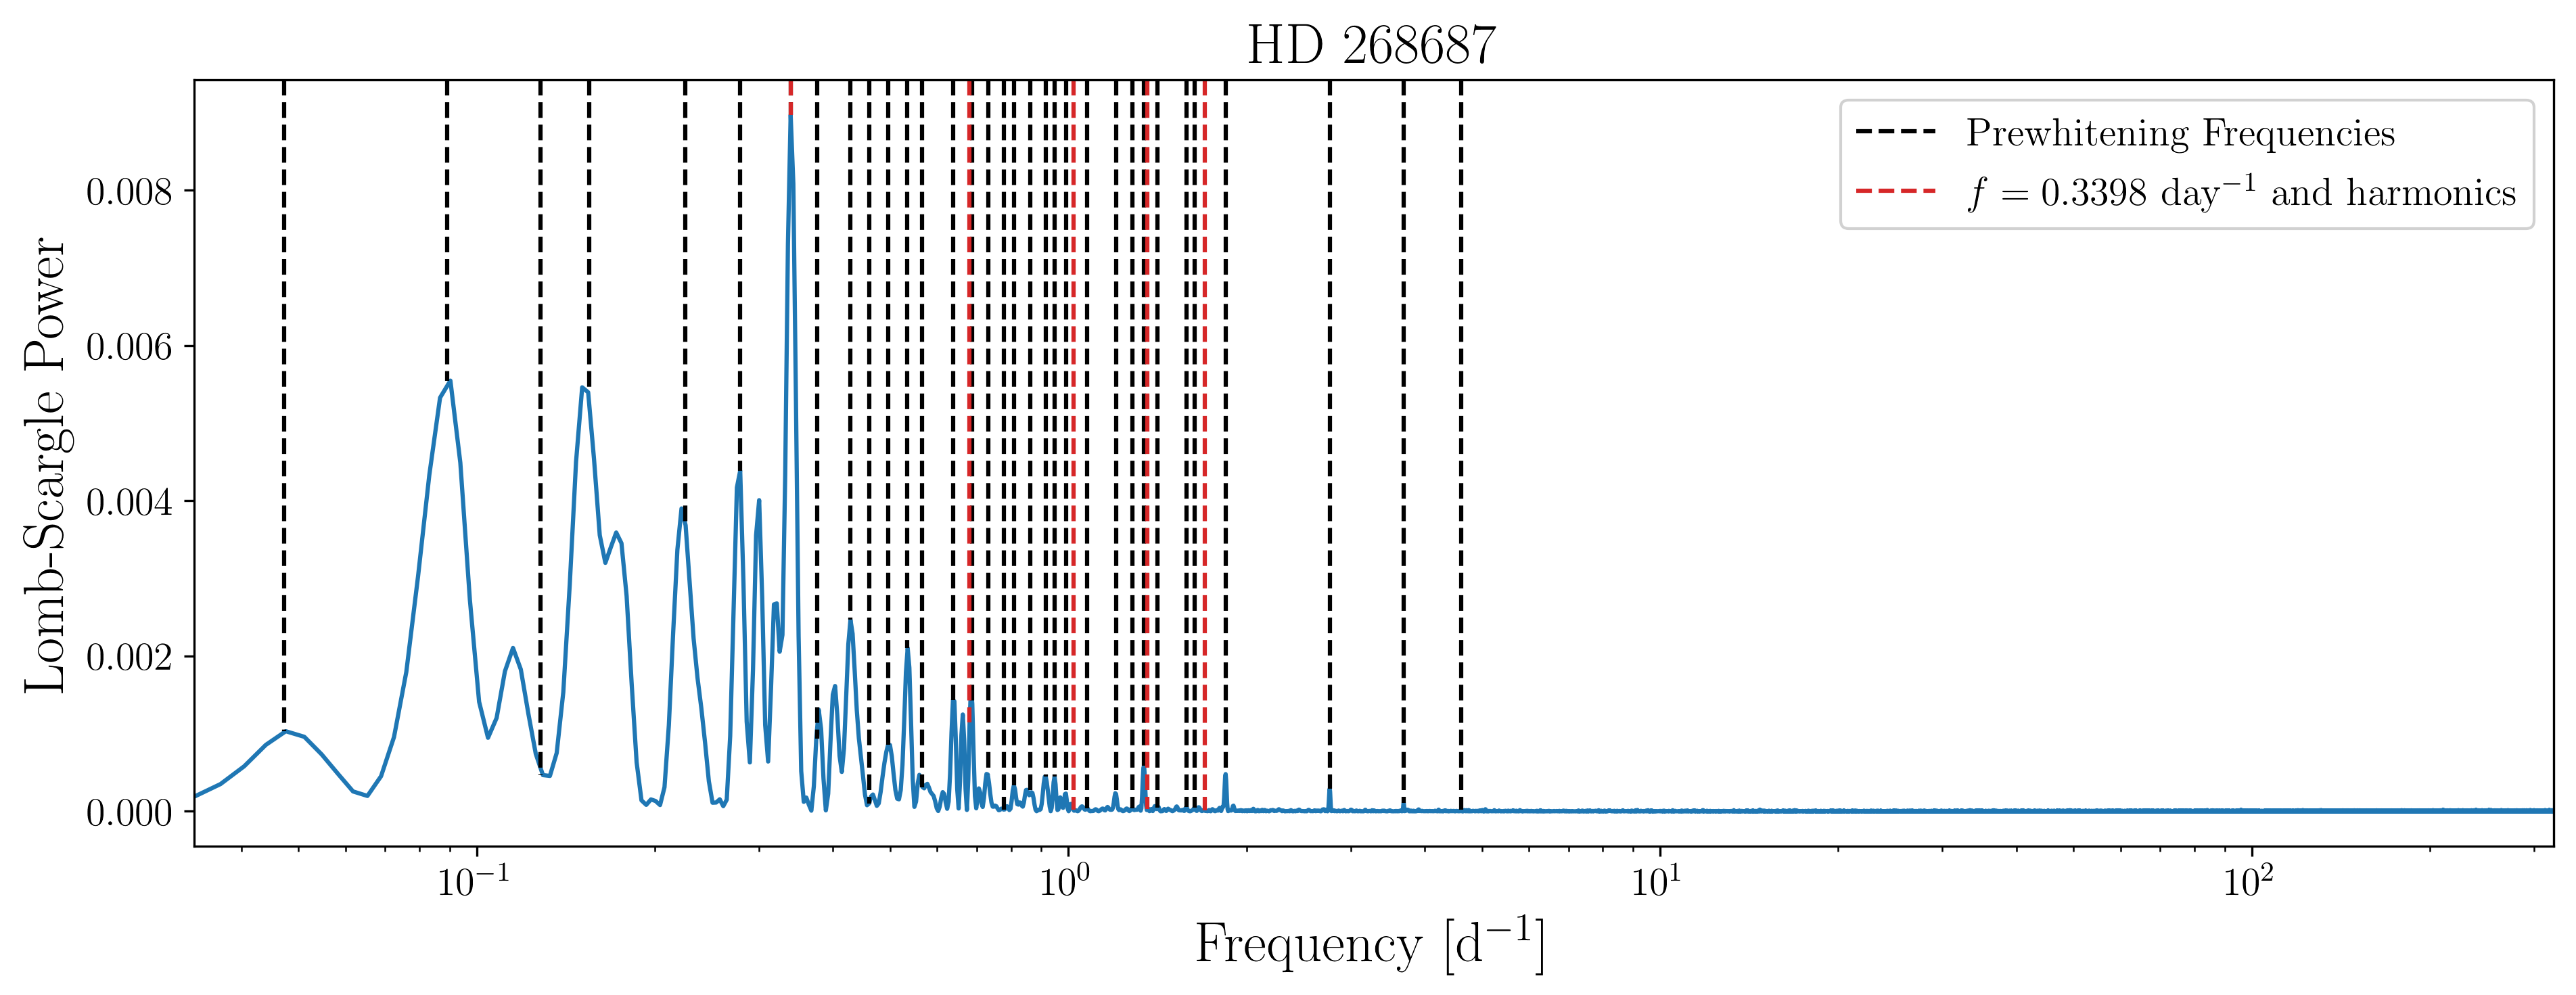

In [16]:
fig = plt.figure(figsize=(15,5),dpi=300)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
lc, p = polynorm(lc, deg=7)
time, flux, err = lc['Time'], lc['NormFlux'], lc['NormErr']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='k',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='k',ls='--')
 
dom = 0.3398155918857977
plt.plot([dom,dom],[ylim[1],power[np.argmin(np.abs(freq-dom))]],c='C3',ls='--',label='$f=0.3398$ day$^{-1}$ and harmonics')
for i in range(2,6):
    plt.plot([i*dom,i*dom],[ylim[1],power[np.argmin(np.abs(freq-i*dom))]],c='C3',ls='--')
    print(i*dom)
    
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20)    
plt.savefig('../plots/HD268687_periodogram.pdf')

In [12]:
for i in range(len(good_fs)-1):
    f, fe = good_fs[i]
    for j in range(i+1,len(good_fs)):
        f_o, fe_o = good_fs[j]
        
        ratio1 = f/f_o
        
        ratio2 = f_o/f
        
        rel_1 = fe/f
        
        rel_2 = fe_o/f_o
        
        ratio1_error = ratio1*np.sqrt(rel_1**2.0 + rel_2**2.0)
        
        ratio2_error = ratio2*np.sqrt(rel_1**2.0 + rel_2**2.0)
        
        if (ratio1 % 1 <= ratio1_error):
            print('harmonic!', f, f_o, f/f_o)
            
        if (ratio2 % 1 <= ratio2_error):
            print('harmonic!', f_o, f, f_o/f)
            
    for k in range(len(good_fs)):
        f1, f1e = good_fs[k]
        fsum = f+f1
        absdifs = np.abs(fsum - good_fs[:,0])
        diferrs = np.sqrt(fe**2.0 + f1e**2.0 + good_fs[:,1]**2.0)
        if np.any(absdifs <= diferrs):
            print('linear combination!', f, f1, good_fs[:,0][absdifs <= diferrs])

linear combination! 0.3398155918857977 0.8631436458082105 [1.20371478]
linear combination! 0.3398155918857977 1.0750741513229978 [1.4145172]
harmonic! 1.3408686601767121 0.08920240524858357 15.03175454114791
linear combination! 0.08920240524858357 0.6879126814770163 [0.77723411]
harmonic! 0.42764474070242536 0.04723986436544038 9.052624228431965
linear combination! 0.42764474070242536 1.2037147753331858 [1.63275628]
linear combination! 0.42764474070242536 1.414517198158934 [1.84286938]
harmonic! 1.2825248644331442 0.12802563681783555 10.017719078078217
harmonic! 4.608997851137809 0.12802563681783555 36.000585239781586
linear combination! 0.12802563681783555 0.8631436458082105 [0.99151843]
linear combination! 0.12802563681783555 1.0750741513229978 [1.20371478]
linear combination! 0.6393477849276231 1.2037147753331858 [1.84286938]
linear combination! 0.6393477849276231 0.9915184282230562 [1.63275628]
harmonic! 1.8428693764308002 0.04723986436544038 39.010894742936685
harmonic! 0.94887341

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


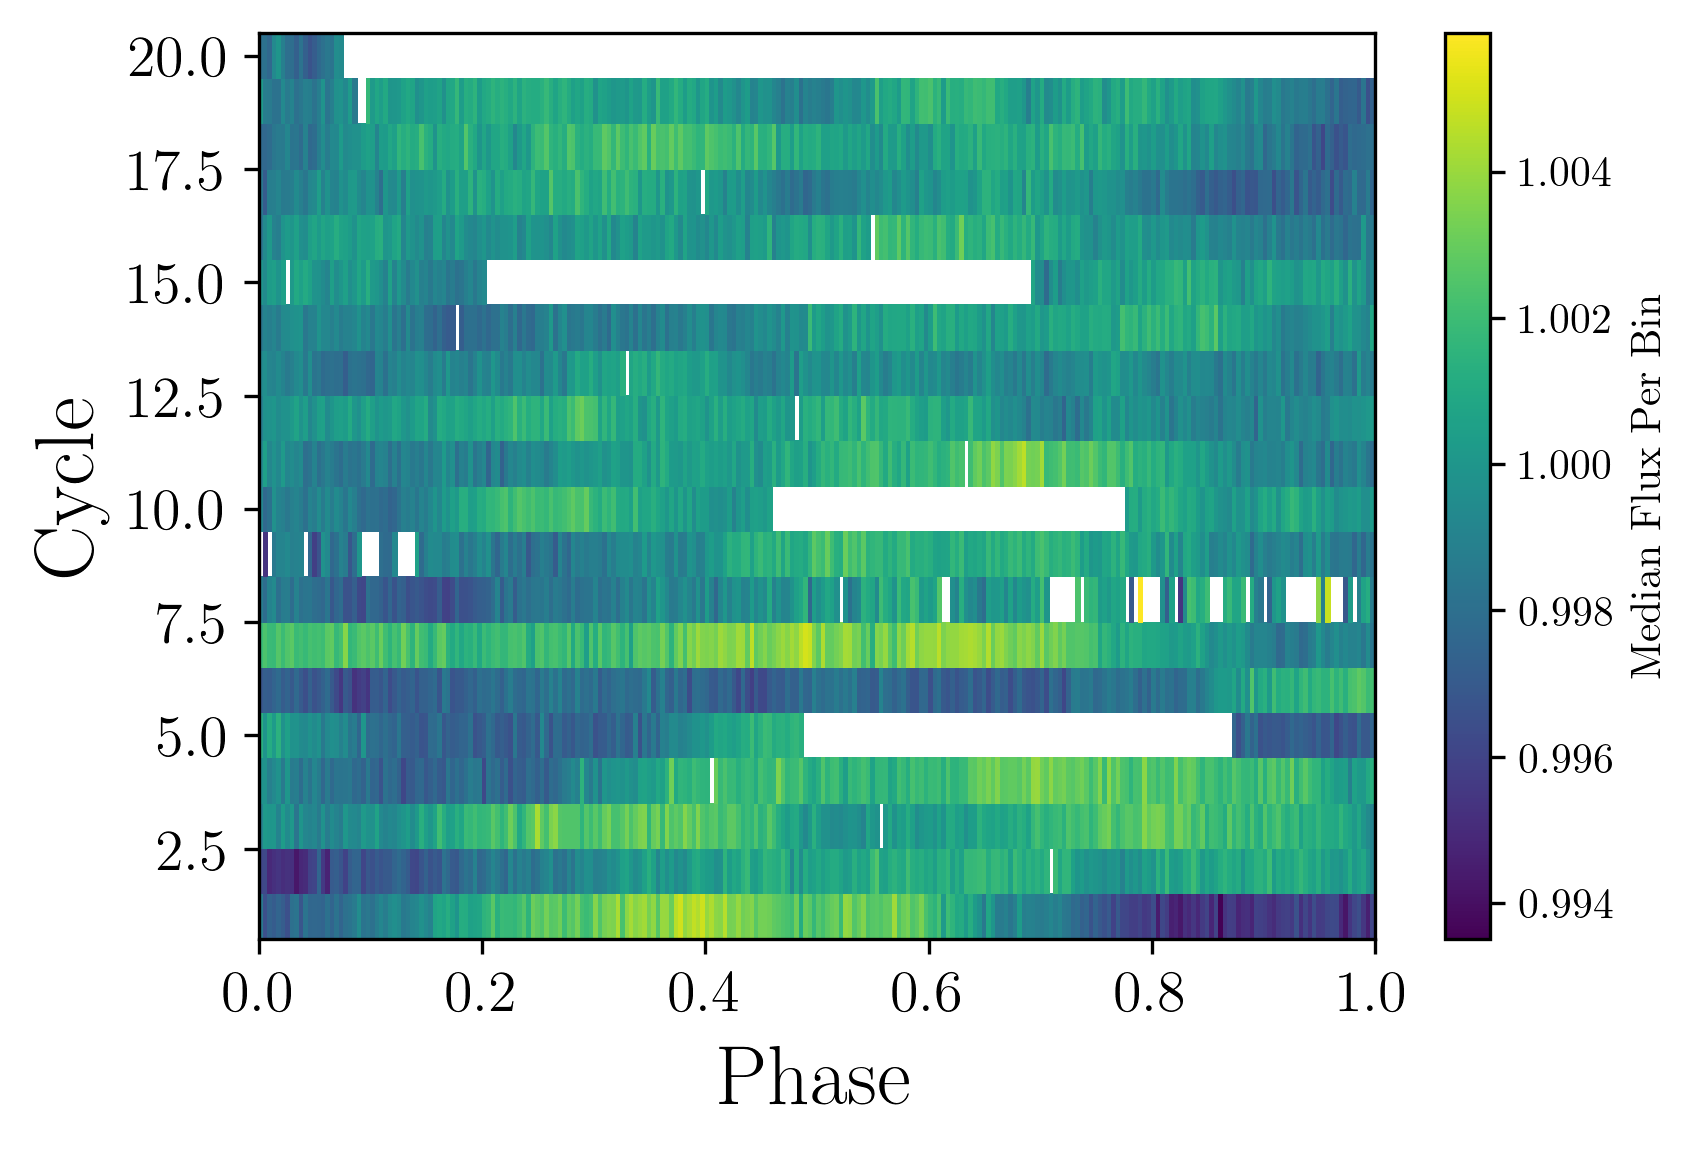

In [16]:
fig = plt.figure(dpi=300)
cycle = np.floor((lc['Time']-np.min(lc['Time']))*dom)
phase = ((lc['Time']-np.min(lc['Time']))*dom) % 1
flux = lc['NormFlux']
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = plt.pcolormesh(XX,YY,H.T)
plt.xlabel('Phase')
plt.ylabel('Cycle')
ax = plt.gca()
plt.colorbar(colobj, ax=ax, label='Median Flux Per Bin')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.savefig('../plots/HD268687_dynamic.pdf')

In [8]:
dom
1/0.339

2.949852507374631

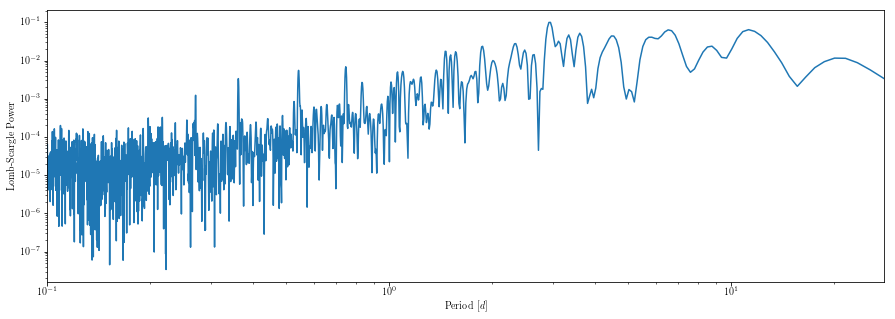

In [9]:
f, p = ls.autopower(minimum_frequency=1.0/28.0,
                    maximum_frequency=1.0/0.1)

fig = plt.figure(figsize=(15,5))
plt.loglog(1.0/f,p)
plt.gca().set(xlabel='Period [$d$]', ylabel='Lomb-Scargle Power', xlim=(0.1,28));

In [10]:
# Now let's do some of the GP stuff on this with twin SHOs
gp = dSHO_maxlikelihood(lc)

Initial log likelihood: 184986.72398259552
Final log likelihood: 187544.4837446413
Maximum Likelihood Soln: OrderedDict([('kernel:terms[0]:log_S0', -13.49745792672745), ('kernel:terms[0]:log_omega0', 0.9097796795498538), ('kernel:terms[1]:log_S0', -16.0), ('kernel:terms[1]:log_Q', -0.9401092705697506), ('kernel:terms[1]:log_omega0', 2.2305463948920363), ('kernel:terms[2]:log_sigma', -7.680636223458878)])


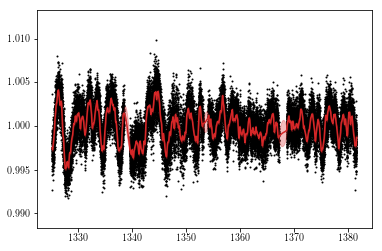

In [11]:
x = np.linspace(np.min(lc['Time']), np.max(lc['Time']), 5000)
pred_mean, pred_var = gp.predict(lc['NormFlux'], x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(lc['Time'], lc['NormFlux'], s=1, c='k')
plt.plot(x, pred_mean, color='C3')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='C3', alpha=0.3,
                 edgecolor="none")

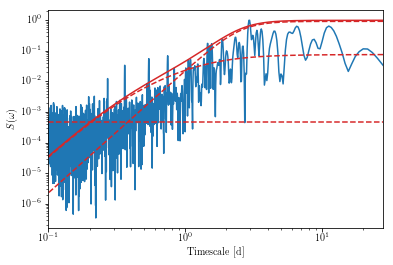

In [12]:
omega = np.exp(np.linspace(np.log(2.0*np.pi/28.0), np.log(2.0*np.pi/0.1), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(1.0/f,p/np.max(p),c='C0')
plt.plot(2.0*np.pi/omega, psd/np.max(psd), color='C3')
for k in gp.kernel.terms:
    plt.plot(2.0*np.pi/omega, k.get_psd(omega)/np.max(psd), "--", color='C3')
plt.axhline(y=np.exp(gp.kernel.terms[2].get_parameter_dict()['log_sigma']),ls='--', color='C3')

plt.yscale("log")
plt.xscale("log")
plt.xlim(2.0*np.pi/omega[-1], 2.0*np.pi/omega[0])
plt.xlabel("Timescale [d]")
plt.ylabel("$S(\omega)$");

In [13]:
sampler, gp = dSHO_emcee(lc, gp)

Running 500 steps of burn-in...


/Users/carina/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/carina/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Running 3000 steps of production...


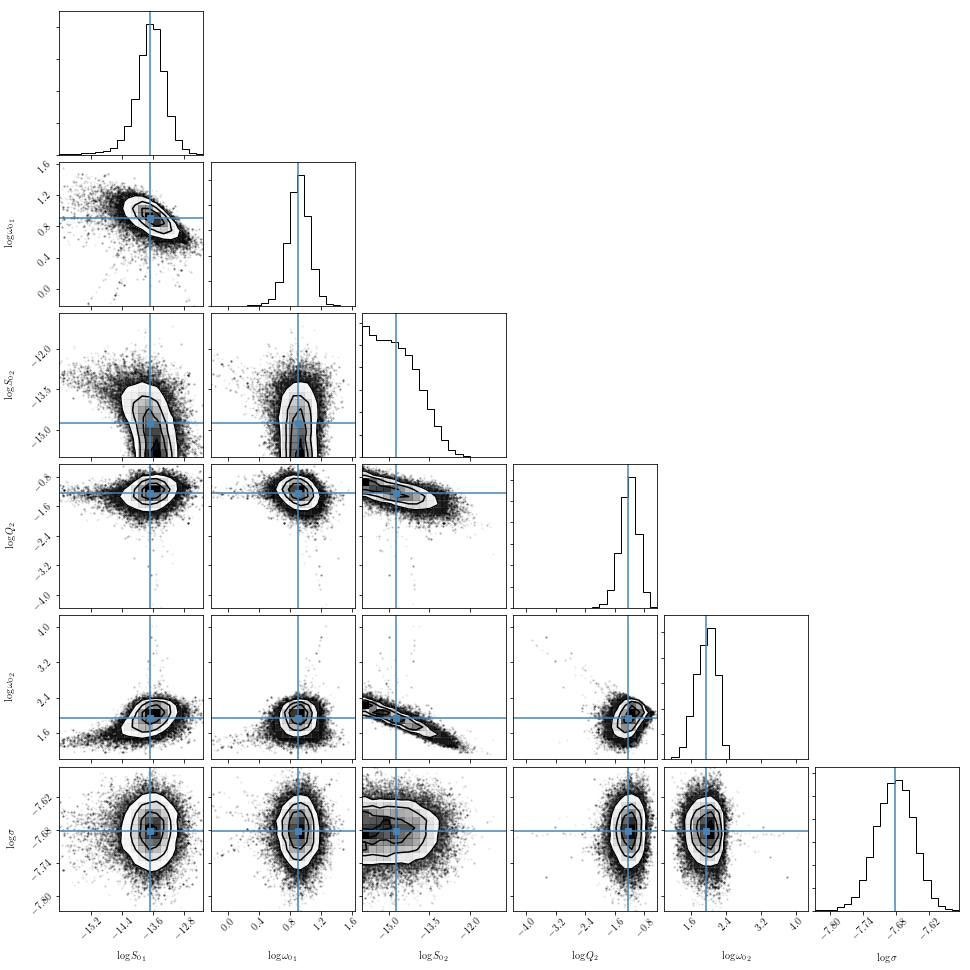

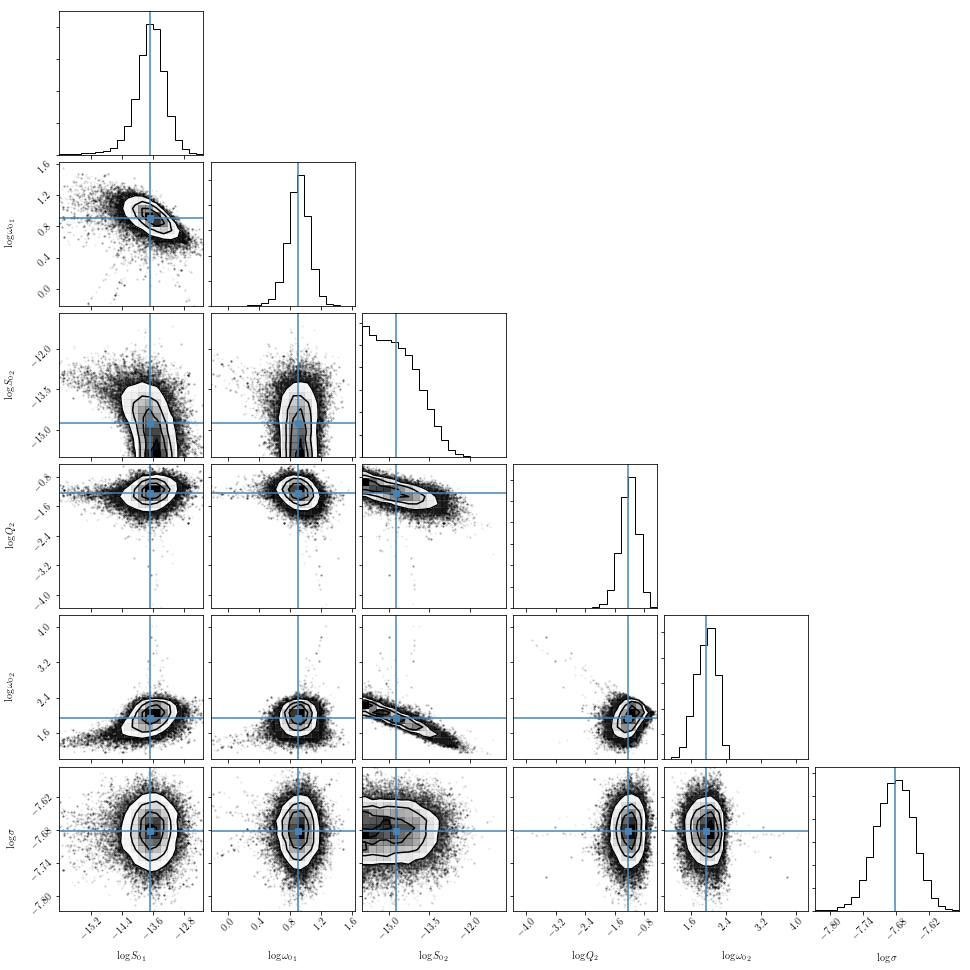

In [14]:
import corner
latex_names = ['$\log{S_0}_1$','$\log{\omega_0}_1$','$\log{S_0}_2$','$\log{Q}_2$','$\log{\omega_0}_2$','$\log{\sigma}$']
true_params = [np.mean(sampler.flatchain[:,i]) for i in range(sampler.flatchain.shape[1])]
corner.corner(sampler.flatchain, truths=true_params,
              labels=latex_names)

In [15]:
[tid]+true_params

[29984014,
 -13.683423480769171,
 0.9058719406272487,
 -14.742234224077091,
 -1.230619048118058,
 1.9376192227821758,
 -7.682152438109031]